In [1]:
# funciones aleatorias
import random
# tomar n elementos de una secuencia
from itertools import islice as take

# # gráficas
import matplotlib.pyplot as plt
# # arreglos multidimensionales
import numpy as np
# # redes neuronales
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# # imágenes
# from skimage import io
# # redes neuronales
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import EMNIST
# # barras de progreso
from tqdm import tqdm

# # inspección de arquitectura
# # https://github.com/TylerYep/torch-summary
from torchsummary import summary

# directorio de datos
DATA_DIR = 'emnist-letters-train'

# MNIST
MEAN = 0.1307
STD = 0.3081

# tamaño del lote
BATCH_SIZE = 128

# reproducibilidad
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

images[0] shape=(28, 28) dtype=uint8


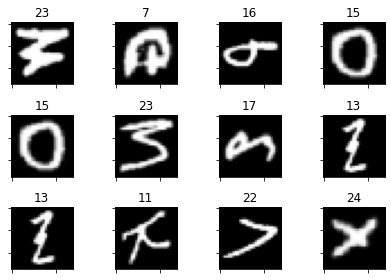

In [10]:
def display_grid(xs, titles, rows, cols):
    fig, ax = plt.subplots(rows, cols)
    for r in range(rows):
        for c in range(cols):
            i = r * rows + c
            ax[r, c].imshow(xs[i], cmap='gray')
            ax[r, c].set_title(titles[i])
            ax[r, c].set_xticklabels([])
            ax[r, c].set_yticklabels([])
    fig.tight_layout()
    plt.show()
    

# creamos un Dataset
ds = EMNIST(
    # directorio de datos
    root=DATA_DIR, 
    split = 'letters',
    # subconjunto de entrenamiento
    train=True, 
    # convertir la imagen a ndarray
    transform=np.array, 
    # descargar el conjunto
    download=True
)


# cargamos algunas imágenes
images, labels = [], []
for i in range(12):
    x, y = ds[i]
    images.append(x)
    labels.append(y)

# desplegamos
print(f'images[0] shape={images[0].shape} dtype={images[0].dtype}')
titles = [str(y) for y in labels]
display_grid(images, titles, 3, 4)

In [4]:
# transformaciones para la imagen
trn_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
trn_ds = EMNIST(
    # directorio de datos
    root=DATA_DIR,
    split = 'letters',
    # subconjunto de entrenamiento
    train=True,
    # transformación
    transform=trn_tsfm
)

# creamos un DataLoader
trn_dl = DataLoader(
    # conjunto
    trn_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# desplegamos un lote de imágenes
for x, y in take(trn_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


In [5]:

# transformaciones para la imagen
tst_tsfm = transforms.Compose([
    # convertimos a torch.Tensor y escalamos a [0,1]
    transforms.ToTensor(),
    # estandarizamos: restamos la media y dividimos sobre la varianza
    transforms.Normalize(MEAN, STD),
])

# creamos un Dataset
tst_ds = EMNIST(
    # directorio de datos
    root=DATA_DIR,
    split = 'letters',
    # subconjunto de entrenamiento
    train=False,
    # transformación
    transform=tst_tsfm
)

# creamos un DataLoader
tst_dl = DataLoader(
    # subconjunto
    tst_ds,
    # tamaño del lote
    batch_size=BATCH_SIZE,
    # desordenar
    shuffle=True
)

# imprimimos forma y tipo del lote
for x, y in take(tst_dl, 1):
    print(f'x shape={x.shape} dtype={x.dtype}')
    print(f'y shape={y.shape} dtype={y.dtype}')

x shape=torch.Size([128, 1, 28, 28]) dtype=torch.float32
y shape=torch.Size([128]) dtype=torch.int64


In [6]:
class ConvBlock(nn.Module):
    
    # inicializador
    def __init__(self, in_channels, out_channels, kernel_size, stride, padding):
        # inicilización del objeto padre, obligatorio
        super(ConvBlock, self).__init__()
        
        # [N, I, H, W] => [N, O, H, W]
        self.cnn_block = nn.Sequential(         
            # conv
            # [N, I, H, W] => [N, O, H, W]
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels, 
                      kernel_size=kernel_size, stride=stride,
                      padding=padding),
            # [N, O, H, W]
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            # [N, O, H/2, W/2]
#             nn.MaxPool2d(kernel_size=2, stride=2)
            
        )       
    
    # metodo para inferencia
    def forward(self, x):
        # [N, I, H, W] => [N, O, H/2, W/2]
        x = self.cnn_block(x)
        return x

In [38]:
class ConvBlock2(nn.Module):
    
    # inicializador
    def __init__(self, in_channels, out_channels):
        # inicilización del objeto padre, obligatorio
        super(ConvBlock2, self).__init__()
        
        # [N, I, H, W] => [N, O, H, W]
        self.cnn_block = nn.Sequential(         
            # conv
            # [N, I, H, W] => [N, O, H, W]
            nn.Conv2d(in_channels=in_channels, 
                      out_channels=out_channels, 
                      kernel_size=3, padding=1),
            # [N, O, H, W]
            nn.BatchNorm2d(out_channels),
            nn.LeakyReLU(),
            # [N, O, H/2, W/2]
            nn.MaxPool2d(kernel_size=2, stride=2)
            
        )       
    
    # metodo para inferencia
    def forward(self, x):
        # [N, I, H, W] => [N, O, H/2, W/2]
        x = self.cnn_block(x)
        return x

In [7]:

# definición del modelo
class CNN(nn.Module):
    
    # inicializador
    def __init__(self):
        
        
        
        # inicilización del objeto padre, obligatorio
        super(CNN, self).__init__()
        self.num_feats = 7*7*64  #8 * 7 * 7
        
        # [N, 1, 28, 28] => [N, 8, 7, 7]
        self.cnn = nn.Sequential(
            # [N, 1, 28, 28] => [N, 4, 14, 14]
            ConvBlock(in_channels=1, out_channels=32, stride=1,kernel_size=3, padding=1),#, kernel_size=3, stride=1, padding =1),
            # [N, 4, 14, 14] => [N, 8, 7, 7]
            ConvBlock(in_channels=32, out_channels=32,stride=2,kernel_size=3, padding=1),#, kernel_size=3, stride=2, padding =1),
            ConvBlock(in_channels=32, out_channels=64,stride=1,kernel_size=3, padding=1),#, kernel_size=3, stride=1, padding =1),
            ConvBlock(in_channels=64, out_channels=64, kernel_size=3, stride=2, padding =1),
        )
    
        # [N, 8, 7, 7] => [N, 8x7x7]
        self.flatten = nn.Flatten() 

        # [N, 8x7x7] => [N, 1]
        self.dense = nn.Linear(self.num_feats, 128)
        self.bn = nn.BatchNorm1d(128)
        self.LReLu = nn.LeakyReLU()
        self.drop = nn.Dropout(p=0.5)
        self.cls = nn.Linear(128,27)
    
    # metodo para inferencia
    def forward(self, x):
        # [N, 1, 28, 28]  => [N, 8, 7, 7]
        x = self.cnn(x)
        # [N, 8, 7, 7] => [N, 8x7x7]
        x = self.flatten(x)
        # [N, 8x7x7] => [N, 10]
        x = self.dense(x)
        x = self.bn(x)
        x = self.LReLu(x)
        x = self.drop(x)
        x = self.cls(x)
        return x
    
model = CNN()
model.to(device)
# print(model)

# model = CNN()
summary(model, (1, 28, 28), device='cuda')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 28, 28]             320
       BatchNorm2d-2           [-1, 32, 28, 28]              64
         LeakyReLU-3           [-1, 32, 28, 28]               0
         ConvBlock-4           [-1, 32, 28, 28]               0
            Conv2d-5           [-1, 32, 14, 14]           9,248
       BatchNorm2d-6           [-1, 32, 14, 14]              64
         LeakyReLU-7           [-1, 32, 14, 14]               0
         ConvBlock-8           [-1, 32, 14, 14]               0
            Conv2d-9           [-1, 64, 14, 14]          18,496
      BatchNorm2d-10           [-1, 64, 14, 14]             128
        LeakyReLU-11           [-1, 64, 14, 14]               0
        ConvBlock-12           [-1, 64, 14, 14]               0
           Conv2d-13             [-1, 64, 7, 7]          36,928
      BatchNorm2d-14             [-1, 6

In [77]:
# creamos un modelo
model = CNN()
model.to(device)

# optimizador
opt = optim.Adam(model.parameters(), lr=1e-3)
# historial de pérdida
loss_hist = []

# ciclo de entrenamiento
EPOCHS = 10
for epoch in range(EPOCHS):
    
    # entrenamiento de una época
    for x, y_true in trn_dl:
        x,y_true = x.to(device), y_true.to(device)
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos la pérdida
        loss = F.cross_entropy(y_lgts, y_true)
        # vaciamos los gradientes
        opt.zero_grad()
        # retropropagamos
        loss.backward()
        # actulizamos parámetros
        opt.step()

    # evitamos que se registren las operaciones 
    # en la gráfica de cómputo
    with torch.no_grad():

        # modelo en modo de evaluación
        model.eval()
        
        losses, accs = [], []
        # validación de la época
        for x, y_true in take(tst_dl, 27):
            x,y_true = x.to(device), y_true.to(device)
            # hacemos inferencia para obtener los logits
            y_lgts = model(x)
            # calculamos las probabilidades
            y_prob = F.softmax(y_lgts, 1)
            # obtenemos la clase predicha
            y_pred = torch.argmax(y_prob, 1)
            
            # calculamos la pérdida
            loss = F.cross_entropy(y_lgts, y_true)
            # calculamos la exactitud
            acc = (y_true == y_pred).type(torch.float32).mean()

            # guardamos históricos
            losses.append(loss.item() * 100)
            accs.append(acc.item() * 100)

        # imprimimos métricas
        loss = np.mean(losses)
        acc = np.mean(accs)
        print(f'E{epoch:2} loss={loss:6.2f} acc={acc:.2f}')
        
        # agregagmos al historial de pérdidas
        loss_hist.append(loss)
        
        # modelo en modo de entrenamiento
        model.train()
        
torch.save(model.state_dict(), 'torch_letters_model.pt')

E 0 loss= 20.78 acc=92.88
E 1 loss= 18.62 acc=93.72
E 2 loss= 17.64 acc=93.89
E 3 loss= 18.06 acc=93.84
E 4 loss= 14.45 acc=94.70
E 5 loss= 17.16 acc=94.30
E 6 loss= 16.90 acc=94.36
E 7 loss= 17.25 acc=94.47
E 8 loss= 15.52 acc=94.99
E 9 loss= 16.63 acc=94.18


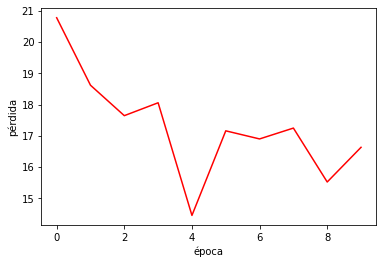

In [78]:
plt.plot(loss_hist, color='red')
plt.xlabel('época')
plt.ylabel('pérdida')
plt.show()

In [8]:
# modelo en modo de evaluación
# model = torch.load('torch_letters_model.pt')
# model.eval()

model.load_state_dict(torch.load('Modelos entrenados/torch_letters_model.pt'))
model.eval()

# evitamos que se registren las operaciones 
# en la gráfica de cómputo
with torch.no_grad(): 
        
    accs = []
    # validación de la época
    for x, y_true in tst_dl:
        x,y_true = x.to(device), y_true.to(device)
        # hacemos inferencia para obtener los logits
        y_lgts = model(x)
        # calculamos las probabilidades
        y_prob = F.softmax(y_lgts, 1)
        # obtenemos la clase predicha
        y_pred = torch.argmax(y_prob, 1)
        
        # calculamos la exactitud
        acc = (y_true == y_pred).type(torch.float32).mean()

        accs.append(acc.item() * 100)

    acc = np.mean(accs)

print(f'Exactitud = {acc:.2f}')

Exactitud = 94.43


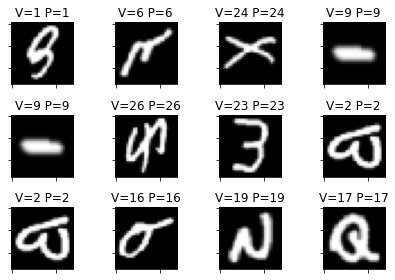

In [9]:
with torch.no_grad(): 
    for x, y_true in take(tst_dl, 1):
        x,y_true = x.to(device), y_true.to(device)
        y_lgts = model(x)
        y_prob = F.softmax(y_lgts, 1)
        y_pred = torch.argmax(y_prob, 1)

    x, y_true, y_pred = x.cpu(),y_true.cpu(),y_pred.cpu()
    x = x[:12].squeeze().numpy()
    y_true = y_true[:12].numpy()
    y_pred = y_pred[:12].numpy()

titles = [f'V={t} P={p}' for t, p in zip(y_true, y_pred)]
display_grid(x, titles, 3, 4)